In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Supervised Machine Learning - 

After dimensionality reduction, we can now use supervised learning methods to train a classifier and make predictions from new signals. In this notebook, I focus of testing and comparing following classifiers - 

* Logistic Regression
* Support Vector Machines
* Naive Bayes
* Decision Trees
* Random Forest
* K-Nearest Neighbours
* Neural Network
<br>
<br>
1. Start with linear classifier (linear regression) and see the performance 
2. Opt for non-linear classifier, explain the choice of parametrization and how your results are affected. 
3. Compare all the classifier models and choose the best one. 

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab as P
import time, glob, os, math
from matplotlib import cm 

from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

#Classifiers
from sklearn.tree import DecisionTreeClassifier as DT, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier



import matplotlib as mpl
mpl.rc('lines', linewidth=2, color='r')
mpl.rc('font', size=16)
mpl.rc('axes', labelsize=16, grid=True)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('legend', fontsize=14)



In [3]:
rs = 12

In [54]:
#Basic Functions and Classes

def read_paramvalue(metafile, parameter):
    '''Return the parameter value from data
    
    Parameters:
    metafile (str) - Metadata filepath
    parameter (str) - parameter name
    '''
   
    assert(os.path.exists(metafile)),"Path to metadata file does not exist"
    
    datafile = open(metafile,'r')
    datafile.seek(0)
    for line in datafile:
        if parameter in line:
            break
    
    line = line.split(',')
    
    #rstrip - remove any trailing charaters
    data_value = line[-1].rstrip()
    datafile.close()
    return data_value


def plot(x, y, xlabel, ylabel, xlim=None, ylim=None, log=None, title=None):     #Create a plot
    '''Generate a line plot of y vx x
    
    Parameters - 
    x,y - Dictionaries - {'label_1':data_1,...'label_n':data_n} - Ensure x and y have same keys/labels
    xlabel, ylabel - strings
    '''
    plt.figure(figsize=(12,6))
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)
    for key in x:
        plt.plot(x[key], y[key], ls=next(linecycler), label=key)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xlim!=None:
        plt.xlim(xlim[0],xlim[1])
    if ylim!=None:
        plt.ylim(ylim[0],ylim[1])
        
    if log=='x': plt.xscale('log')
    elif log=='y': plt.yscale('log')
    elif log=='both': 
        plt.xscale('log')
        plt.yscale('log')
        
    if title!=None:
        plt.title(title, y=1.04, fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()
    
    
def scatter(ax, x, y, clr, xlabel, ylabel, title=None, legend=True):     #Create a scatter plot
    '''Generate a scatter plot 
       ax - subplot
       x, y - numpy arrays
       xlabel, ylabel title - strings  
    '''
    clr_label = {0:'orange', 1:'forestgreen', 2:'deepskyblue',3:'gold', 4:'b', 5:'k', 6:'red', 7:'darkmagenta' }
    names = {'AlignedSpins':0,'NonSpinning':1,'Precessing':2}
    #target_names = np.vectorize(names.get)(clr)
    target_labels =  np.vectorize(clr_label.get)(clr) #(target_names)
   
    ax.scatter(x,y,facecolors=target_labels, edgecolors=None) 

    orange_dot= plt.scatter([], [], color=clr_label[0], label='AlignedSpin')
    green_dot= plt.scatter([], [], color=clr_label[1], label='NonSpinning')
    blue_dot= plt.scatter([], [], color=clr_label[2], label='Precessing')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title!=None:
        ax.set_title(title)
    if legend: ax.legend(handles=[orange_dot, green_dot, blue_dot])
    return ax


class waveform():
    
    def __init__(self, wf_filepath, wf_metadata_file):
        
        assert os.path.exists(wf_filepath), "Waveform file at path %s not found"%wf_filepath
            
        self.t, self.hp, self.hx = np.loadtxt(wf_filepath, unpack=True, usecols=(0,1,2))
        
        self.dt  = self.t[2]-self.t[1]
        
        self._amplitude  = np.sqrt(self.hp**2 + self.hx**2)
        self._phase = -1.*np.unwrap(np.arctan2(self.hp,self.hx))
        self._gwfreq  = np.gradient(self.phase)/np.gradient(self.t)
        
        self._freq, self._hf_plus, self._hf_cross = self.fourier_transform()
        self._hf_amplitude = np.sqrt(np.absolute(self._hf_plus)**2 + np.absolute(self._hf_cross)**2)
        
        #Read parameters from metadata file
        metafile = wf_metadata_file
        self.name =  read_paramvalue(metafile, 'name')
        
        self.m1 = read_paramvalue(metafile, 'mass1')
        self.m2 = read_paramvalue(metafile, 'mass2')
        
        self.a1x = read_paramvalue(metafile, 'spin1x')
        self.a1y = read_paramvalue(metafile, 'spin1y')
        self.a1z = read_paramvalue(metafile, 'spin1z')
        
        self.a2x = read_paramvalue(metafile, 'spin2x')
        self.a2y = read_paramvalue(metafile, 'spin2y')
        self.a2z = read_paramvalue(metafile, 'spin2z')
    
        self.ecc = read_paramvalue(metafile, 'eccentricity')
        self.spin_type = read_paramvalue(metafile, 'spin-type')
        self.f_low = read_paramvalue(metafile, 'f_lower_at_1MSUN')
        
    #Declare amplitude, phase and GW frequency as properties so any modification to strain data (for eg windowing)
    #is automatically accounted for. 
    
    def get_amplitude(self):
        return self._amplitude

    
    def set_amplitude(self): 
        print('Amplitude Setter function called')
        self._amplitude = np.sqrt(self.hp**2 + self.hx**2)

    amplitude = property(get_amplitude, set_amplitude)
    
    
    def get_phase(self):
        return self._phase

    def set_phase(self): 
        self._phase = -1.*np.unwrap(np.arctan2(self.hp, self.hx))
     
    phase = property(get_phase, set_phase)
    
    
    def get_gwfreq(self):
        return self._gwfreq

    def set_gwfreq(self): 
        self._gwfreq = np.gradient(self.phase)/np.gradient(self.t)

    gwfreq = property(get_gwfreq, set_gwfreq) 
    
    
    def  get_hf_plus(self):
        return self._hf_plus

    def set_hf_plus(self): 
        self._hf_plus = np.abs(np.fft.fft(self.hp))*self.dt
   
    hf_plus= property(get_hf_plus, set_hf_plus) 
    
    
    def get_hf_cross(self):
        return self._hf_cross

    def set_hf_cross(self): 
        self._hf_cross = np.abs(np.fft.fft(self.hx))*self.dt
    
    hf_cross= property(get_hf_cross, set_hf_cross) 
    
   
    def get_hf_amplitude(self):
        return self._hf_amplitude

    def set_hf_amplitude(self): 
        self._hf_amplitude = np.sqrt(np.absolute(self._hf_plus)**2 + np.absolute(self._hf_cross)**2)
    
    hf_amplitude= property(get_hf_amplitude, set_hf_amplitude) 
   
    def get_freq(self):
        return self._freq

    def set_freq(self): 
        self._freq = np.fft.fftfreq(len(self.hf_plus), self.dt)
   
    freq = property(get_freq, set_freq)
    
   
    def update_properties(self):
        print('Update properties called')
        t = self.t
        re = self.hp
        im = self.hx
       
        self.set_amplitude()
        self.set_phase()
        self.set_gwfreq()
        self.set_hf_plus()
        self.set_hf_cross()
        self.set_freq()
        
    def fourier_transform(self ):
        hf_plus  = np.abs(np.fft.fft(self.hp))*self.dt
        hf_cross = np.abs(np.fft.fft(self.hx))*self.dt
        hf = np.sqrt(hf_plus**2  + hf_cross**2)
        freq = np.fft.fftfreq(len(hf), self.dt)
        return freq, hf_plus, hf_cross

    def mean_centring(self):
        max_amp = np.amax(self.amp)
        tmax = self.t[amp==max_amp]
        self.t = self.t-tmax
        
         
    def window_beginning(self, window_length):
        old_t_start = t[0]
        new_t_start = old_t_start + window_length
        
        self.hp = self.hp[self.t>new_t_start]
        self.hx = self.hx[self.t>new_t_start]
        
        self.t = self.t[self.t>new_t_start]
        self.update_properties()
        
    def window_ends(self, window_length):
        old_t_end = t[-1]
        new_t_end = old_t_end - window_length
        
        self.hp = self.hp[self.t<new_t_end]
        self.hx = self.hx[self.t<new_t_end]
        
        self.t = self.t[self.t<new_t_end]
        


class classifier():
  
    def __init__(self):
        
        self.name = ""
        self.training_fraction = 0
        
        self.cv_score       = 0
        self.training_score = 0
        self.testing_score  = 0
        self.total_time     = 0
        self.best_params    = 0
       
        

In [60]:
#Principal Component Analysis
def func_PCA(n_comp, data):
    ''' Compute n PCA components and apply to given data
    --------------------------------------------
    n_comp - type int - number of PCA components
    data - type numpy matrix - training data
    '''
    
    num_samples, num_features = np.shape(data)
    time_init = time.time()
    clf = PCA(svd_solver='full', n_components=n_comp, random_state=rs)   
    transformed_data = clf.fit_transform(data)
    #var = clf.explained_variance_
    score = clf.score(data)
    time_pca = time.time() - time_init
    
    #print("Projected {} samples from {} to {} with score {}" .format(num_samples, num_features, n_comp, score))
    return transformed_data, time_pca


def ml_classifier(clf, params, inputdata, outputdata, trainsize, pca_comp, plot_decisiontree=False, verbose=0,parallelize=False):
    '''Compute the best optimal parameters and scores for classifier clf using GridSearch algorithm 
    and apply it to standardized data. 
    ----------------------------------------------------------------------------------------
    clf - ML classifier (sklearn clf object)
    params (type dict) - dict with parameter name as key and range of parameter values
    to search over (check GridSearch algorithm)
    inputdata (numpy matrix) - input dataset X
    outputdata (numpy array) - output dataset Y
    trainsize (float) - fraction of total data to be trained (between 0 to 1)
    pca_comp(int) - number of PCA components
    plot_decisiontree (boolean) - if true, then plot the decision tree 
    verbose(int) - print summary of results
    parallelize (boolean) - parallelize grid search 
    '''
    
    start_time = time.time()
    data = np.copy(inputdata)
    y    = np.copy(outputdata)
    data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)
    
    #Standardize the data before applying PCA
    SS_data = StandardScaler()
    data_train =  SS_data.fit_transform(data_train)
    data_test = SS_data.transform(data_test)
    
    standardization_time = time.time() 
    
    #Apply PCA
    data_train_pca, pca_train_time = func_PCA(pca_comp, data_train)
    data_test_pca, pca_test_time = func_PCA(pca_comp, data_test)
    pca_time = time.time() 
    
    #Perform a grid search over given parameters
    param_grid=params 
    if parallelize:
        nprocs=-1
    else:
        nprocs=1
    search = GridSearchCV(clf, param_grid, cv=5, n_jobs=nprocs)
    
    #Compute the cross validation, training and test scores
    cv_scores = cross_val_score(search, data_train_pca, y_train, cv=5)
    search.fit(data_train_pca, y_train)
    score_train = search.score(data_train_pca, y_train)
    score_test = search.score(data_test_pca,y_test)
    
    gridsearch_time = time.time() 
    
    if plot_decisiontree:
        plt.figure()
        plot_tree(clf)
        plt.close()
        
    if verbose>0:
        
        print("Training Size = %g (%.3g), Test Size = %g(%0.3g)"%(trainsize, len(y_train), (1-trainsize), len(y_test)))
        print("Time Taken: Standardization = %g, PCA = %g, GridSearch = %g, Total Time = %g"%(standardization_time-start_time, pca_time-standardization_time, gridsearch_time-pca_time, gridsearch_time-start_time))
        print("Cross-Validation Score = %.3g (+/- %0.2g) , Training Score = %g, Testing Score = %.3g \n\n"%(cv_scores.mean(), cv_scores.std()*2, score_train, score_test))
        
    if verbose>1:
        print("Grid Search Results: \n{}\n\n".format(search.best_params_))
        
    
    clf_performance = classifier()
    clf_performance.name = clf.__class__.__name__
    clf_performance.training_fraction = trainsize
    clf_performance.cv_score       = cv_scores
    clf_performance.training_score = score_train
    clf_performance.testing_score  = score_test
    clf_performance.total_time     = gridsearch_time-start_time
    clf_performance.best_params    = search.best_params_
    
    return clf_performance



In [6]:
os.chdir('/localdata2/bkhamesra3/MachineLearning/GW-MLClassification/Data/')


## Building Data

Collect all waveforms and spin-type. Convert the spin-type category from string to numerical labels. 

In [7]:
#Loading the Dataset

waveform_collection = []
GT_filepaths = sorted(glob.glob("FilteredData/GT*.txt"))
SXS_filepaths = sorted(glob.glob("FilteredData/SXS*.txt"))


for wf_file_gt in GT_filepaths:
    
    metadata_file = os.path.join('Metadata','Metadata_'+os.path.basename(wf_file_gt).split('.txt')[0]+'.csv')
    wf = waveform(wf_file_gt, metadata_file)
    waveform_collection.append(wf)
    
for wf_file_sxs in SXS_filepaths:
    
    metadata_file = os.path.join('Metadata','Metadata_'+os.path.basename(wf_file_sxs).split('.txt')[0]+'.csv')
    wf = waveform(wf_file_sxs, metadata_file)
    waveform_collection.append(wf)
    


In [13]:
#Concatenate plus and cross polarization
def concat_wf_timedata(wf):
    '''Concatenate the real and imaginary components of waveform in time domain'''
    #print(wf.name, wf.spin_type)
    data = np.concatenate((wf.hp, wf.hx))
    
    return data

def concat_wf_freqdata(wf):
    '''Concatenate the plus and cross polarization components of waveform in frequency domain'''
    #print(wf.name, wf.spin_type)
    data = np.concatenate((np.absolute(wf.hf_plus)[wf.freq>0], np.absolute(wf.hf_cross)[wf.freq>0]))
    
    return data


waveform_collection  = np.asarray(waveform_collection)

# waveform_data_ht - each row represents concatenated data corresponding to one waveform in order (t, real, imag)
waveform_data_ht = list(map(concat_wf_timedata, waveform_collection))
waveform_data_ht = np.matrix(waveform_data_ht)

# waveform_data_hf - each row represents concatenated data corresponding to one waveform in order (f, FT(real), FT(imag))
waveform_data_hf = list(map(concat_wf_freqdata, waveform_collection))
waveform_data_hf = np.matrix(waveform_data_hf)

# Output
y = [wf.spin_type for wf in waveform_collection]

# Convert spin labels from string to numbers
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(y)



In [65]:
#Train a classifier and analyse results

def analyse_classifier(clf, params, data, y, trainingdata_frac, pca_numcomp, verbose=0, show_plot=True, parallelize=False):
    '''Train classifier for different training data size and evaluate the performance. 
    ----------------------------------------------------------------------------------------
    clf - ML classifier (sklearn clf object)
    params (type dict) - dict with parameter name as key and range of parameter values
    to search over (check GridSearch algorithm)
    data (numpy matrix) - input dataset X
    y (numpy array) - output dataset Y
    traindata_frac(float) - fraction of total data to be trained (between 0 to 1)
    pca_numcomp(int) - number of PCA components
    show_plot(boolean) - display plot of performance of classifier
    verbose(int) - print summary of results
    parallelize (boolean) - parallelize grid search 
    '''
    clf_cv_score_mean, clf_cv_score_std, clf_test_score_arr, clf_total_time_arr = np.zeros((4, len(trainingdata_frac)))
    clf_output = {}
    
    if verbose>0:print("Training Size \t Cross Validation Score  Train Score \t Testing size \t Testing Score ")
    print('-'*100)

    for i in range(len(trainingdata_frac)):
        
        clf_performance = ml_classifier(clf, params, data, y, trainingdata_frac[i], pca_numcomp,verbose=verbose,parallelize=parallelize)
        clf_cv_score_mean[i]   =  clf_performance.cv_score.mean()
        clf_cv_score_std[i]    =  clf_performance.cv_score.std()
        clf_test_score_arr[i]  =  clf_performance.testing_score
        clf_total_time_arr[i]  =  clf_performance.total_time
      
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))      
    
    cv_plot = ax1.plot(trainingdata_frac, clf_cv_score_mean, c='C1', label=r'$CV Score \pm 2\sigma$')
    ax1.plot(trainingdata_frac, clf_cv_score_mean+2*clf_cv_score_std, ls='--', c='C1' )
    ax1.plot(trainingdata_frac, clf_cv_score_mean-2*clf_cv_score_std, ls='--', c='C1' )
    ax1.fill_between(trainingdata_frac, clf_cv_score_mean-2*clf_cv_score_std, clf_cv_score_mean, color='C1', alpha=0.3)
    ax1.fill_between(trainingdata_frac, clf_cv_score_mean+2*clf_cv_score_std, clf_cv_score_mean, color='C1', alpha=0.3)
    ax1.plot(trainingdata_frac, clf_test_score_arr, c='C0', label='Test Score')
     
    ax1.set_xlabel('Training Size')
    ax1.set_ylabel('Scores')
    ax1.legend()
    
    ax2.plot(trainingdata_frac, clf_total_time_arr )
    ax2.set_xlabel('Training Size')
    ax2.set_ylabel('Total Time')
            
    if show_plot:fig.suptitle(clf_performance.name, fontsize=15)
    if show_plot: plt.show()
    plt.close()
    
    return clf_performance

### Classifier: Logistic Regression 

Fixed Parameters - 


----------------------------------------------------------------------------------------------------


/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/nethome/bkhamesra3/softwares/anaconda3/lib/pyth

/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


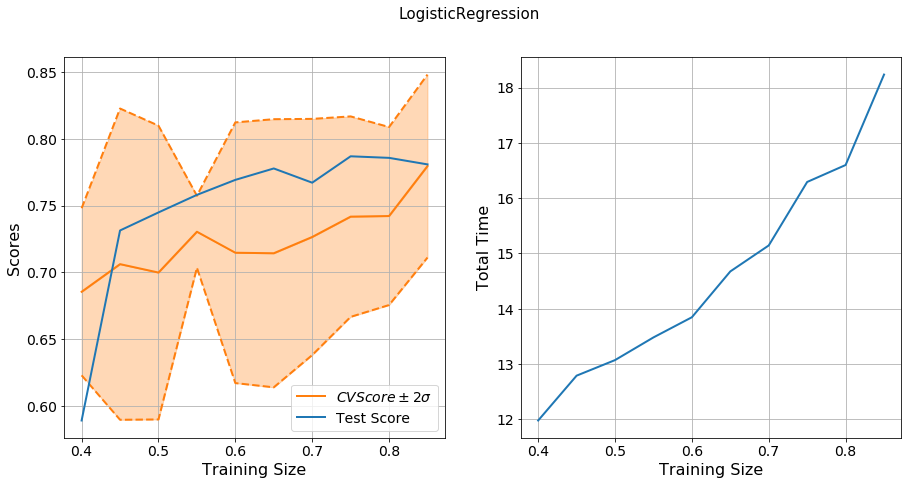

CPU times: user 25.7 s, sys: 6 s, total: 31.7 s
Wall time: 2min 26s


In [67]:
%%time
clf = LogisticRegression(penalty='l2', max_iter=1000,random_state=rs)  
params={'C':10.**np.arange(0,2,0.4),'solver':['newton-cg', 'lbfgs','sag', 'saga']}

        
rf = {}
verbose=0 

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.05)

dt = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, verbose=verbose, parallelize=True, show_plot=True)


### Classifier  - Decision Trees

In [68]:
%%time
dt = {}
clf = DT(random_state=rs)
params={'criterion':['gini', 'entropy'],'max_depth':[6,7,8,9]}
verbose=0  

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.05)

dt = analyse_classifier(clf, params, waveform_data_ht, n, 45, verbose=verbose, show_plot=True, figname='Decision Tree')

TypeError: analyse_classifier() got an unexpected keyword argument 'figname'

### Classifier  - Random Forest

In [69]:
%%time
clf = RandomForestClassifier(n_jobs=1, random_state=rs)
params={'n_estimators':[5,10,20,40],'criterion':['gini', 'entropy'],'max_depth':[6,7,8,9]}
    
rf = {}
verbose=0  

#Finding optimal training data size    
n  = np.arange(0.4,0.9,0.05)

dt = analyse_classifier(clf, params, waveform_data_ht, n, 45, verbose=verbose, show_plot=True, figname='Random Forest')

TypeError: analyse_classifier() got an unexpected keyword argument 'figname'

### Classifier : K-Nearest Neighbours (KNN)

In [ ]:
%%time
clf = KNeighborsClassifier()
params={'n_neighbors':[1,3,5,7],'weights':['uniform', 'distance']}
        
rf = {}
verbose=0  

#Finding optimal training data size    
n  = np.arange(0.4,0.9,0.05)

dt = analyse_classifier(clf, params, waveform_data_ht, n, 45, verbose=verbose, show_plot=True, figname='KNN')

In [ ]:
print clf

### Classifier : Support Vector Machines (SVM)

Fixed Parameters - 
* decision_function_shape - 

In [ ]:
%%time
clf = SVC(decision_function_shape='ovr', random_state=rs)  
params={'C':10.**np.arange(0,2,0.4),'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

        
rf = {}
verbose=0 

#Finding optimal training data size    
n  = np.arange(0.4,0.9,0.1)

dt = analyse_classifier(clf, params, waveform_data_ht, n, 45, verbose=verbose, parallelize=True, show_plot=True, figname='SVM')


### Classifier : Naive Bayes

In [ ]:
%%time
clf = GaussianNB()  
params={} #'C':10.**np.arange(0,2,0.4),'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

        
rf = {}
verbose=0 

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.1)

dt = analyse_classifier(clf, params, waveform_data_ht, n, 45, verbose=verbose, parallelize=True, show_plot=True, figname='SVM')


### Classifier : Neural Network

In [ ]:
%%time
clf = MLPClassifier(alpha=0.1, solver='adam', activation='relu', random_state=rs)  
params={ 'hidden_layer_sizes':[10,50,100,200]}
        #'activation':['identity', 'logistic', 'tanh', 'relu']} 

        
rf = {}
verbose=2 

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.6)

dt = analyse_classifier(clf, params, waveform_data_ht, n, 45, verbose=verbose, parallelize=True, show_plot=True, figname='SVM')


In [1]:
print(clf)

NameError: name 'clf' is not defined

In [25]:
def func(i, d):
    key = i+1
    value = i+2
    d[key] = value
    #print(d)
    
dic = {}
func(1, dic)
func(2,dic)
print(dic)

{2: 3, 3: 4}
